In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 17.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 19.4MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-04 08:54:46--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-04 08:54:47--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2f056fad8b830b8a400c21a52b.dl.dropboxusercontent.com/cd/0/get/BKDGvPioXfcRKc3HG20csVu9Eellxe3tapukIv0OoVNmeRDP0ivNUR_Ka0cCviijpZBccLxqluYEjOO5RTzti7sl0uyt1q8NByvcktOtp80q9_05DD743wMG8nfM5cfRYY8/file?dl=1# [following]
--2021-03-04 08:54:47--  https://uc2f056fad8b830b8a400c21a52b.dl.dropboxusercontent.com/cd/0/get/BKDGvPioXfcRKc3HG20csVu9Eellxe3tapukIv0OoVNmeRDP0ivNUR_Ka0cCviijpZBccLxqluYEjOO5RTzti

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='efficientnet_b1'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


SuggestedLRs(lr_min=0.10964782238006592, lr_steep=3.981071586167673e-06)

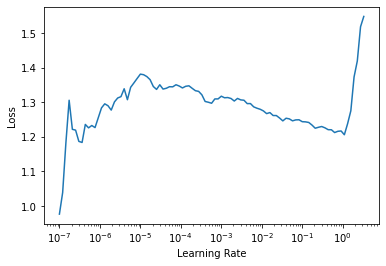

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.392195,0.994457,0.503058,0.483568,0.323899,00:31
1,1.292725,0.906729,0.521407,0.509579,0.418239,00:31


Better model found at epoch 0 with valid_loss value: 0.9944573640823364.


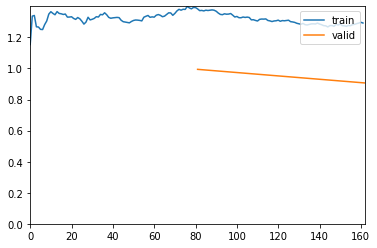

Better model found at epoch 1 with valid_loss value: 0.9067293405532837.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.224998,0.894305,0.513761,0.500000,0.405660,00:38
1,1.210045,0.896960,0.500000,0.481781,0.374214,00:38
2,1.231348,0.859378,0.515290,0.501730,0.455975,00:38
3,1.187843,0.838243,0.519878,0.506757,0.471698,00:38
4,1.150284,0.828162,0.513761,0.500000,0.477987,00:38
5,1.117963,0.801194,0.536697,0.524590,0.503145,00:38
6,1.052842,0.797113,0.541284,0.530612,0.490566,00:38
7,1.044277,0.791203,0.538226,0.527397,0.484277,00:38
8,1.053861,0.791121,0.530581,0.521912,0.411950,00:37
9,1.090395,0.770628,0.558104,0.548822,0.512579,00:37


Better model found at epoch 0 with valid_loss value: 0.894304633140564.


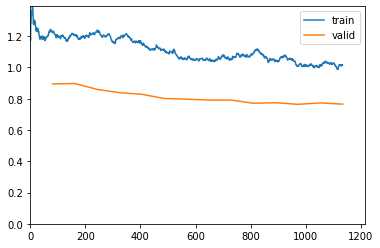

Better model found at epoch 2 with valid_loss value: 0.8593775033950806.
Better model found at epoch 3 with valid_loss value: 0.838243305683136.
Better model found at epoch 4 with valid_loss value: 0.8281617760658264.
Better model found at epoch 5 with valid_loss value: 0.8011937737464905.
Better model found at epoch 6 with valid_loss value: 0.7971132397651672.
Better model found at epoch 7 with valid_loss value: 0.7912031412124634.
Better model found at epoch 8 with valid_loss value: 0.7911208271980286.
Better model found at epoch 9 with valid_loss value: 0.7706283330917358.
Better model found at epoch 11 with valid_loss value: 0.7638159394264221.
No improvement since epoch 11: early stopping


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

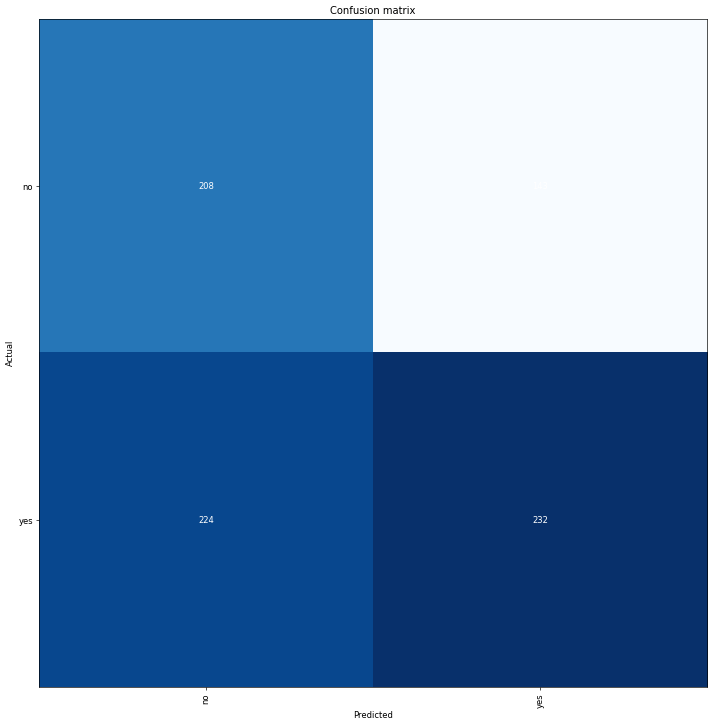

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5452292561531067.


(#4) [0.7568894624710083,0.5452292561531067,0.6186666666666667,0.5087719298245614]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.276279,0.842913,0.579511,0.555270,0.679245,00:33
1,0.986962,0.767793,0.576453,0.585062,0.443396,00:33


Better model found at epoch 0 with valid_loss value: 0.842913031578064.


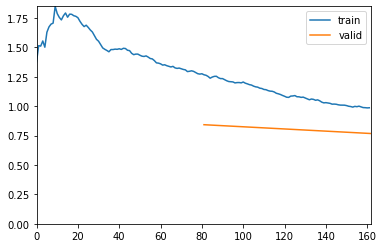

Better model found at epoch 1 with valid_loss value: 0.7677925825119019.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=6.309573450380412e-07)

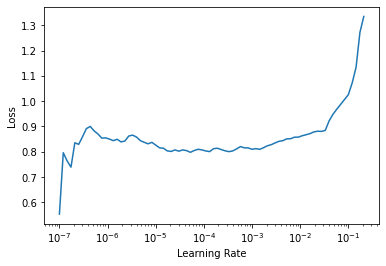

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.036201,17.554010,0.484709,0.452261,0.283019,00:39
1,1.092017,1.124372,0.489297,0.466102,0.345912,00:39
2,1.061158,0.835821,0.490826,0.482759,0.660377,00:40
3,0.975153,0.827112,0.510703,0.496350,0.427673,00:40
4,0.895332,0.754075,0.483180,0.476303,0.632075,00:40
5,0.890232,1.643455,0.509174,0.491803,0.283019,00:40
6,0.959121,0.816723,0.489297,0.483193,0.723270,00:39
7,0.947959,0.897977,0.551988,0.568306,0.327044,00:40


Better model found at epoch 0 with valid_loss value: 17.55401039123535.


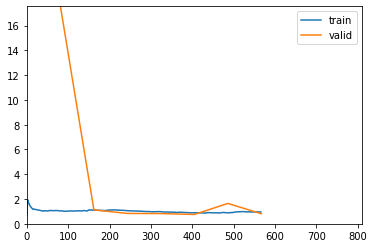

Better model found at epoch 1 with valid_loss value: 1.1243724822998047.
Better model found at epoch 2 with valid_loss value: 0.8358211517333984.
Better model found at epoch 3 with valid_loss value: 0.8271116018295288.
Better model found at epoch 4 with valid_loss value: 0.75407475233078.
No improvement since epoch 4: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

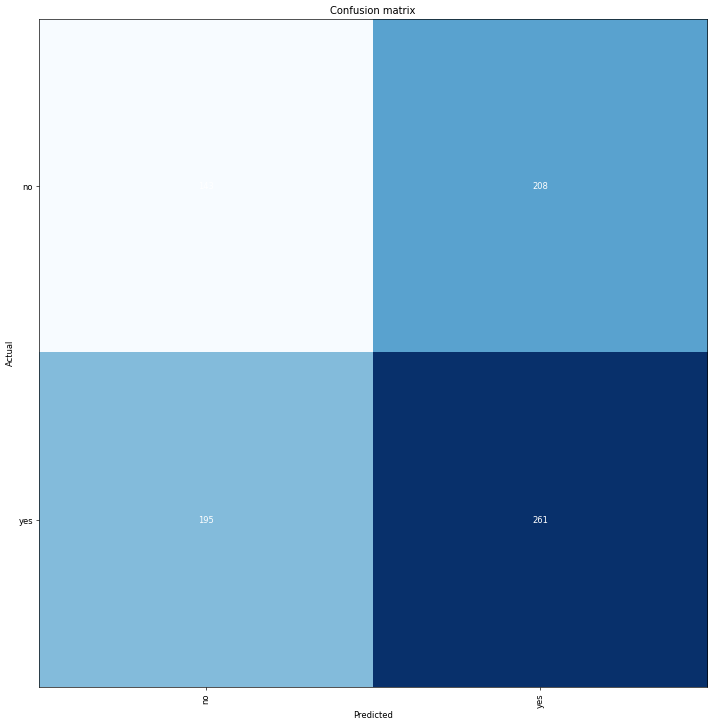

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5006195902824402.


(#4) [0.7610285878181458,0.5006195902824402,0.5565031982942431,0.5723684210526315]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=8.31763736641733e-06)

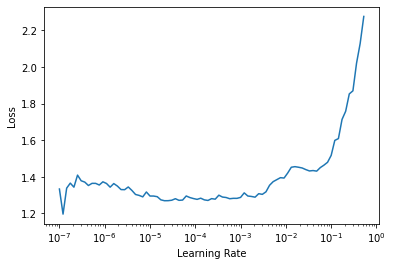

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.214638,1.125710,0.550459,0.538961,0.522013,00:32
1,1.082063,0.774223,0.593272,0.595588,0.509434,00:32


Better model found at epoch 0 with valid_loss value: 1.125709891319275.


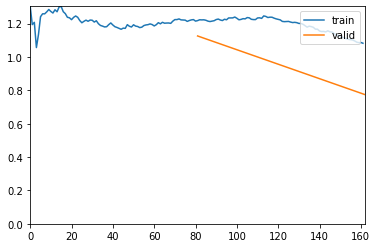

Better model found at epoch 1 with valid_loss value: 0.774222731590271.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.770337,0.695350,0.608563,0.613971,0.525157,00:39
1,0.745380,0.686695,0.591743,0.586441,0.544025,00:38
2,0.730735,0.680932,0.585627,0.558025,0.710692,00:39
3,0.696438,0.664553,0.607034,0.578406,0.707547,00:39
4,0.675144,0.641395,0.628440,0.645914,0.522013,00:39
5,0.654903,0.636961,0.660550,0.693548,0.540881,00:39
6,0.650972,0.638765,0.662080,0.638968,0.701258,00:39
7,0.649326,0.635245,0.671254,0.663492,0.657233,00:39
8,0.628684,0.637760,0.678899,0.730769,0.537736,00:39
9,0.616906,0.625672,0.665138,0.666667,0.622642,00:38


Better model found at epoch 0 with valid_loss value: 0.6953498125076294.


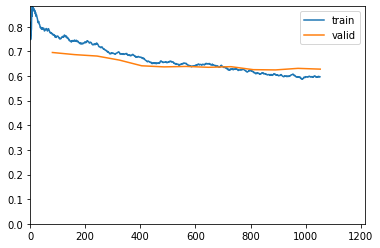

Better model found at epoch 1 with valid_loss value: 0.6866953372955322.
Better model found at epoch 2 with valid_loss value: 0.6809315085411072.
Better model found at epoch 3 with valid_loss value: 0.6645532846450806.
Better model found at epoch 4 with valid_loss value: 0.6413953304290771.
Better model found at epoch 5 with valid_loss value: 0.6369606256484985.
Better model found at epoch 7 with valid_loss value: 0.6352449655532837.
Better model found at epoch 9 with valid_loss value: 0.6256722211837769.
Better model found at epoch 10 with valid_loss value: 0.6246175765991211.
No improvement since epoch 10: early stopping


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

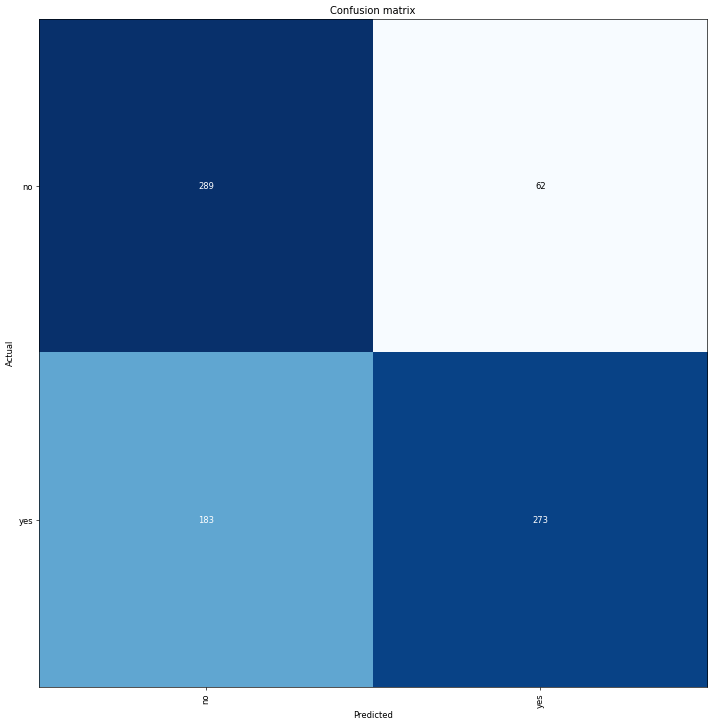

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6964064240455627.


(#4) [0.6180794835090637,0.6964064240455627,0.8149253731343283,0.5986842105263158]

## MixUp

In [31]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [32]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.247669,0.967814,0.574924,0.577519,0.468553,00:36
1,1.070326,0.769139,0.582569,0.573290,0.553459,00:37


Better model found at epoch 0 with valid_loss value: 0.9678143262863159.


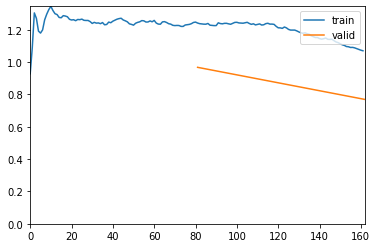

Better model found at epoch 1 with valid_loss value: 0.769138753414154.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.821390,0.694440,0.587156,0.595238,0.471698,00:42
1,0.759785,0.670191,0.591743,0.584158,0.556604,00:42
2,0.744589,0.653426,0.636086,0.642857,0.566038,00:43
3,0.704378,0.660094,0.625382,0.708571,0.389937,00:43
4,0.685804,0.639221,0.633027,0.628289,0.600629,00:42
5,0.683358,0.626988,0.648318,0.638365,0.638365,00:42
6,0.674719,0.634800,0.639144,0.666667,0.515723,00:42
7,0.665314,0.639430,0.659021,0.791411,0.405660,00:42
8,0.655508,0.635134,0.637615,0.666667,0.509434,00:42


Better model found at epoch 0 with valid_loss value: 0.6944397687911987.


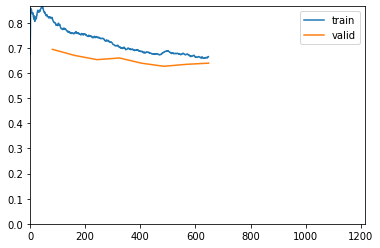

Better model found at epoch 1 with valid_loss value: 0.6701912879943848.
Better model found at epoch 2 with valid_loss value: 0.6534257531166077.
Better model found at epoch 4 with valid_loss value: 0.6392208933830261.
Better model found at epoch 5 with valid_loss value: 0.6269875764846802.
No improvement since epoch 5: early stopping


In [33]:
learn.fine_tune(15,freeze_epochs=2)

In [34]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

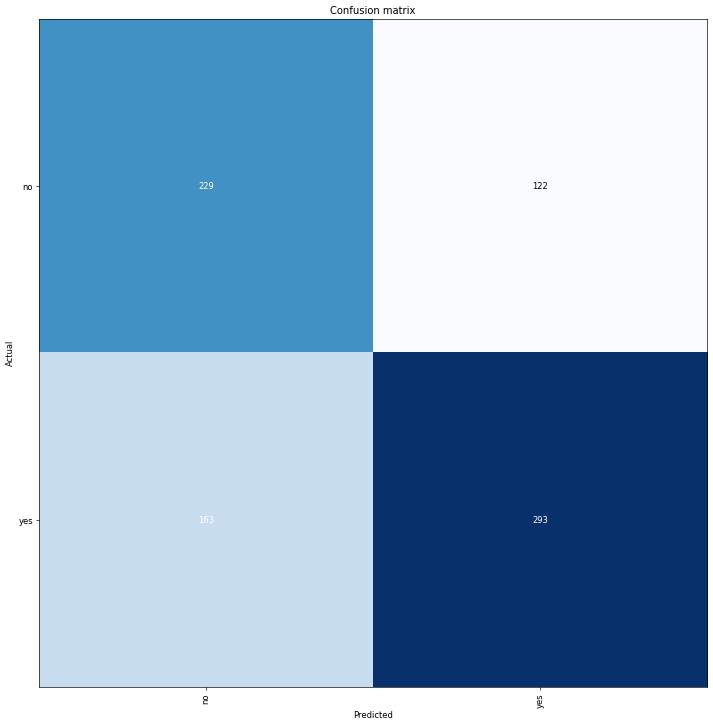

In [35]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6468401551246643.


(#4) [0.619131863117218,0.6468401551246643,0.7060240963855422,0.6425438596491229]

## Ranger + Flat cosin Anneal

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.302595,0.966091,0.532110,0.528037,0.355346,00:32
1,1.269809,0.944987,0.533639,0.532663,0.333333,00:32


Better model found at epoch 0 with valid_loss value: 0.9660913348197937.


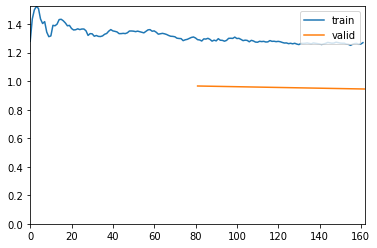

Better model found at epoch 1 with valid_loss value: 0.9449871778488159.


In [38]:
learn.fit_flat_cos(2,lr=1e-3)

In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

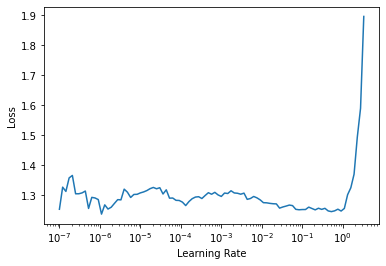

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.177298,0.868120,0.561162,0.573460,0.380503,00:39
1,1.044428,0.757526,0.584098,0.587121,0.487421,00:40
2,0.923290,0.700598,0.623853,0.631387,0.544025,00:39
3,0.789980,0.696021,0.625382,0.685279,0.424528,00:39
4,0.729102,0.658122,0.639144,0.655303,0.544025,00:39
5,0.699578,0.619837,0.666667,0.686567,0.578616,00:39
6,0.650069,0.631451,0.663609,0.675000,0.594340,00:39
7,0.630859,0.607487,0.683486,0.693380,0.625786,00:39
8,0.634711,0.603612,0.677370,0.713147,0.562893,00:39
9,0.608277,0.607117,0.672783,0.706349,0.559748,00:39


Better model found at epoch 0 with valid_loss value: 0.8681201934814453.


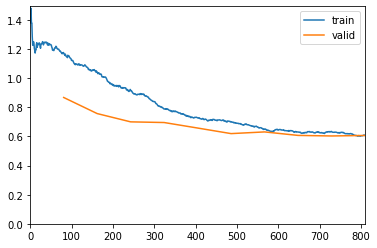

Better model found at epoch 1 with valid_loss value: 0.7575259208679199.
Better model found at epoch 2 with valid_loss value: 0.7005982398986816.
Better model found at epoch 3 with valid_loss value: 0.6960211396217346.
Better model found at epoch 4 with valid_loss value: 0.658122181892395.
Better model found at epoch 5 with valid_loss value: 0.6198374629020691.
Better model found at epoch 7 with valid_loss value: 0.6074867248535156.
Better model found at epoch 8 with valid_loss value: 0.6036120057106018.


In [41]:
learn.fit_flat_cos(10,lr=1e-2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6815365552902222.


(#4) [0.5936518907546997,0.6815365552902222,0.8158730158730159,0.5635964912280702]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.367692,0.950873,0.493884,0.483029,0.581761,00:32
1,1.243803,0.900834,0.504587,0.491429,0.540881,00:32


Better model found at epoch 0 with valid_loss value: 0.9508728384971619.


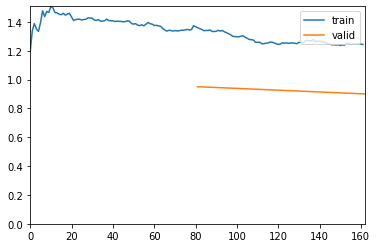

Better model found at epoch 1 with valid_loss value: 0.9008342027664185.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=9.12010818865383e-07)

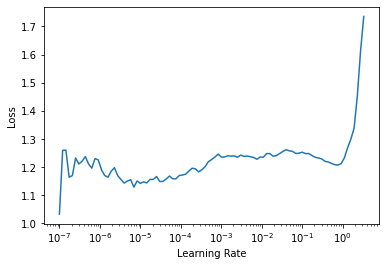

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.144225,0.788678,0.548930,0.533333,0.578616,00:40
1,1.032717,0.716146,0.610092,0.598131,0.603774,00:39
2,0.900532,0.669150,0.634557,0.632997,0.591195,00:39
3,0.803779,0.662568,0.603976,0.605735,0.531447,00:39
4,0.731529,0.642974,0.655963,0.678161,0.556604,00:39
5,0.703613,0.630333,0.654434,0.663121,0.588050,00:39
6,0.674525,0.626813,0.669725,0.709016,0.544025,00:39
7,0.669208,0.620523,0.674312,0.705882,0.566038,00:39
8,0.645425,0.618161,0.694190,0.713768,0.619497,00:39
9,0.639506,0.614157,0.672783,0.720339,0.534591,00:40


Better model found at epoch 0 with valid_loss value: 0.7886776328086853.


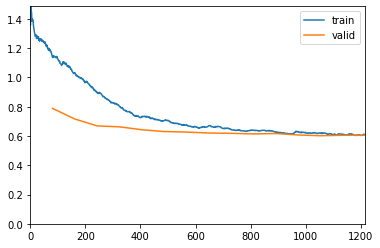

Better model found at epoch 1 with valid_loss value: 0.7161455750465393.
Better model found at epoch 2 with valid_loss value: 0.6691498160362244.
Better model found at epoch 3 with valid_loss value: 0.6625680923461914.
Better model found at epoch 4 with valid_loss value: 0.642973780632019.
Better model found at epoch 5 with valid_loss value: 0.6303329467773438.
Better model found at epoch 6 with valid_loss value: 0.6268128752708435.
Better model found at epoch 7 with valid_loss value: 0.6205228567123413.
Better model found at epoch 8 with valid_loss value: 0.618161141872406.
Better model found at epoch 9 with valid_loss value: 0.6141565442085266.
Better model found at epoch 11 with valid_loss value: 0.6069620847702026.
Better model found at epoch 12 with valid_loss value: 0.6018989682197571.


In [49]:
learn.fit_flat_cos(15,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7013630867004395.


(#4) [0.5976216793060303,0.7013630867004395,0.8062678062678063,0.6206140350877193]

## Ranger +Flat + Label + MixUp

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.375307,0.988996,0.515290,0.501109,0.710692,00:33
1,1.274981,0.936764,0.522936,0.507109,0.672956,00:32


Better model found at epoch 0 with valid_loss value: 0.9889959692955017.


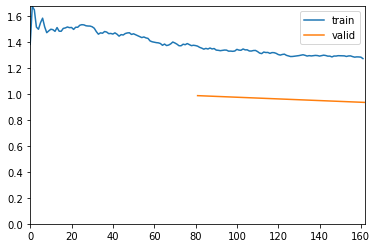

Better model found at epoch 1 with valid_loss value: 0.9367635846138.


In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.226483,0.823591,0.550459,0.532258,0.622642,00:39
1,1.112846,0.743772,0.579511,0.557029,0.660377,00:40
2,0.979929,0.727322,0.571865,0.556548,0.588050,00:40
3,0.857676,0.687076,0.610092,0.584450,0.685535,00:39
4,0.800738,0.669147,0.597859,0.579710,0.628931,00:39
5,0.744425,0.658943,0.625382,0.616613,0.606918,00:39
6,0.710748,0.655509,0.613150,0.585752,0.698113,00:39
7,0.708489,0.649121,0.625382,0.620462,0.591195,00:39
8,0.689906,0.647411,0.648318,0.678862,0.525157,00:39
9,0.679395,0.642315,0.648318,0.631737,0.663522,00:40


Better model found at epoch 0 with valid_loss value: 0.8235912919044495.


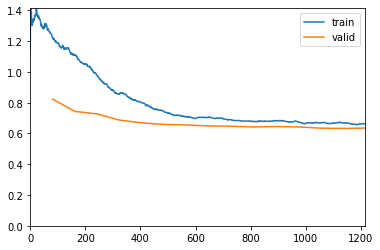

Better model found at epoch 1 with valid_loss value: 0.7437722682952881.
Better model found at epoch 2 with valid_loss value: 0.7273216843605042.
Better model found at epoch 3 with valid_loss value: 0.6870762705802917.
Better model found at epoch 4 with valid_loss value: 0.6691473126411438.
Better model found at epoch 5 with valid_loss value: 0.6589429974555969.
Better model found at epoch 6 with valid_loss value: 0.6555091738700867.
Better model found at epoch 7 with valid_loss value: 0.649120569229126.
Better model found at epoch 8 with valid_loss value: 0.647411048412323.
Better model found at epoch 9 with valid_loss value: 0.6423149704933167.
Better model found at epoch 12 with valid_loss value: 0.6346302628517151.
Better model found at epoch 13 with valid_loss value: 0.6329228281974792.


In [56]:
learn.fit_flat_cos(15,lr=1e-2)

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

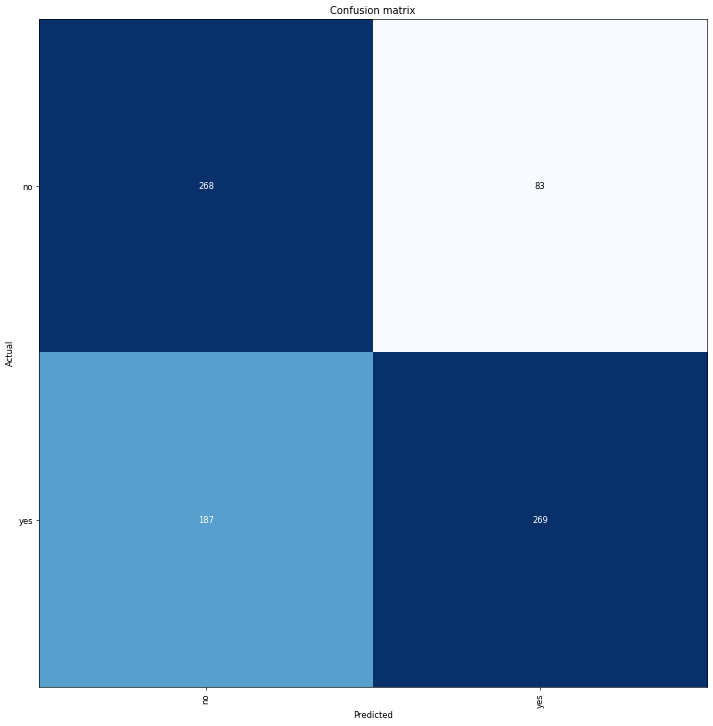

In [58]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [59]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6654275059700012.


(#4) [0.620282769203186,0.6654275059700012,0.7642045454545454,0.5899122807017544]

## Ranger + Flat + MixUp

In [60]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.339585,0.940755,0.522936,0.508824,0.544025,00:38
1,1.314869,0.939413,0.513761,0.500000,0.594340,00:38


Better model found at epoch 0 with valid_loss value: 0.9407545328140259.


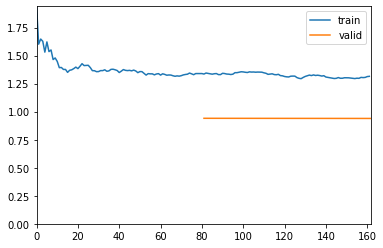

Better model found at epoch 1 with valid_loss value: 0.9394132494926453.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.199572,0.784530,0.565749,0.561594,0.487421,00:43
1,1.092714,0.728711,0.587156,0.574534,0.581761,00:43
2,0.975911,0.718165,0.594801,0.592334,0.534591,00:43
3,0.861872,0.677816,0.590214,0.616822,0.415094,00:43
4,0.776776,0.662245,0.614679,0.643478,0.465409,00:43
5,0.741642,0.653550,0.610092,0.632911,0.471698,00:43
6,0.713760,0.637185,0.628440,0.658228,0.490566,00:43
7,0.697893,0.628402,0.649847,0.683128,0.522013,00:43
8,0.662566,0.615337,0.668196,0.709544,0.537736,00:43
9,0.664796,0.605407,0.654434,0.686992,0.531447,00:43


Better model found at epoch 0 with valid_loss value: 0.7845304012298584.


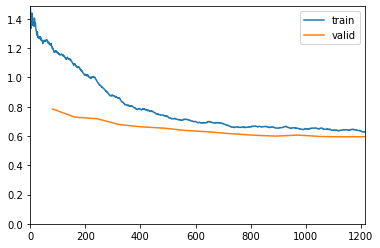

Better model found at epoch 1 with valid_loss value: 0.7287106513977051.
Better model found at epoch 2 with valid_loss value: 0.7181649208068848.
Better model found at epoch 3 with valid_loss value: 0.6778159141540527.
Better model found at epoch 4 with valid_loss value: 0.6622447371482849.
Better model found at epoch 5 with valid_loss value: 0.6535503268241882.
Better model found at epoch 6 with valid_loss value: 0.6371852159500122.
Better model found at epoch 7 with valid_loss value: 0.628401517868042.
Better model found at epoch 8 with valid_loss value: 0.6153371930122375.
Better model found at epoch 9 with valid_loss value: 0.6054068803787231.
Better model found at epoch 10 with valid_loss value: 0.5991836786270142.
Better model found at epoch 12 with valid_loss value: 0.5965217351913452.
Better model found at epoch 13 with valid_loss value: 0.5943320989608765.


In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [66]:
learn.dls = dlsTest

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6827757358551025.


(#4) [0.6023027300834656,0.6827757358551025,0.8246753246753247,0.5570175438596491]

## Ranger + MixUp

In [68]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.300843,0.967091,0.512232,0.498542,0.537736,00:38
1,1.265866,0.909151,0.532110,0.516575,0.588050,00:38


Better model found at epoch 0 with valid_loss value: 0.9670908451080322.


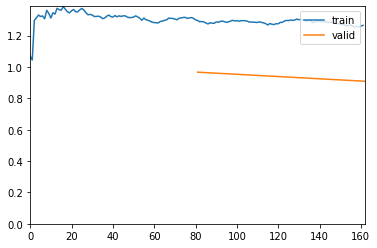

Better model found at epoch 1 with valid_loss value: 0.9091511964797974.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.225376,0.905408,0.519878,0.505814,0.547170,00:43
1,1.207568,0.903884,0.512232,0.498667,0.588050,00:43
2,1.201041,0.889304,0.510703,0.497159,0.550314,00:43
3,1.163633,0.851842,0.521407,0.507599,0.525157,00:43
4,1.171238,0.829389,0.519878,0.506369,0.500000,00:43
5,1.141268,0.823024,0.530581,0.516418,0.544025,00:43
6,1.116211,0.805133,0.547401,0.537415,0.496855,00:43
7,1.094682,0.804601,0.544343,0.537037,0.455975,00:43
8,1.066086,0.787095,0.553517,0.544218,0.503145,00:43
9,1.062621,0.783834,0.539755,0.527687,0.509434,00:43


Better model found at epoch 0 with valid_loss value: 0.9054078459739685.


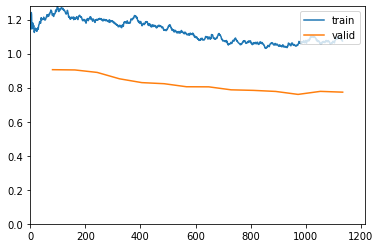

Better model found at epoch 1 with valid_loss value: 0.903883695602417.
Better model found at epoch 2 with valid_loss value: 0.8893041610717773.
Better model found at epoch 3 with valid_loss value: 0.851841926574707.
Better model found at epoch 4 with valid_loss value: 0.8293892741203308.
Better model found at epoch 5 with valid_loss value: 0.8230239152908325.
Better model found at epoch 6 with valid_loss value: 0.8051329255104065.
Better model found at epoch 7 with valid_loss value: 0.80460125207901.
Better model found at epoch 8 with valid_loss value: 0.7870951890945435.
Better model found at epoch 9 with valid_loss value: 0.7838342785835266.
Better model found at epoch 10 with valid_loss value: 0.7775745987892151.
Better model found at epoch 11 with valid_loss value: 0.7601791024208069.
No improvement since epoch 11: early stopping


In [70]:
learn.fine_tune(15,freeze_epochs=2)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5662949085235596.


(#4) [0.7737780213356018,0.5662949085235596,0.6635802469135802,0.47149122807017546]

## Faltten + MixUp

In [74]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.294730,0.898588,0.571865,0.595960,0.371069,00:37
1,0.956038,0.707697,0.610092,0.642534,0.446541,00:37


Better model found at epoch 0 with valid_loss value: 0.8985876441001892.


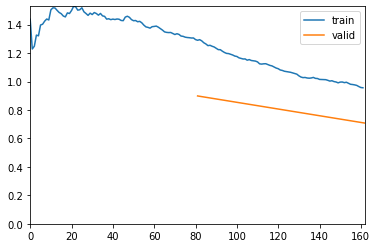

Better model found at epoch 1 with valid_loss value: 0.7076974511146545.


In [75]:
learn.fit_flat_cos(2,lr=1e-3)

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.996271,2.844897,0.480122,0.474057,0.632075,00:42
1,0.946967,50.757984,0.496942,0.443299,0.135220,00:43
2,1.037977,0.694693,0.513761,0.000000,0.000000,00:42
3,1.013506,1.358011,0.486239,0.486239,1.000000,00:43
4,0.954298,1.063681,0.516820,0.545455,0.037736,00:43
5,0.938068,0.732104,0.506116,0.495164,0.805031,00:42


Better model found at epoch 0 with valid_loss value: 2.8448967933654785.


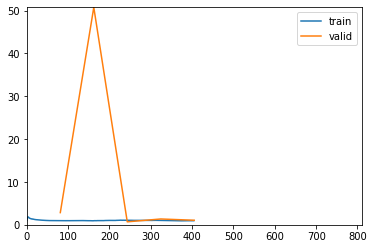

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with valid_loss value: 0.6946927309036255.
No improvement since epoch 2: early stopping


In [77]:
learn.fit_flat_cos(10,lr=1e-2)

In [78]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [79]:
learn.dls = dlsTest

In [80]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7104446887969971,0.4349442422389984,0.0,0.0]

## Ranger + Label

In [81]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.329686,1.079659,0.507645,0.496183,0.817610,00:37
1,1.334887,0.993494,0.506116,0.494929,0.767296,00:38


Better model found at epoch 0 with valid_loss value: 1.07965886592865.


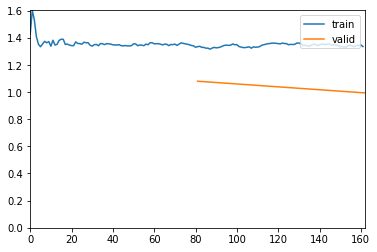

Better model found at epoch 1 with valid_loss value: 0.99349445104599.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.225733,0.969189,0.506116,0.494867,0.757862,00:43
1,1.251082,0.991648,0.512232,0.499025,0.805031,00:43
2,1.255060,0.915266,0.530581,0.512141,0.729560,00:43
3,1.178588,0.866939,0.512232,0.498812,0.660377,00:43
4,1.172315,0.842538,0.530581,0.514066,0.632075,00:43
5,1.120883,0.851282,0.532110,0.513889,0.698113,00:43
6,1.128309,0.823378,0.542813,0.523929,0.654088,00:43
7,1.126934,0.806896,0.544343,0.526596,0.622642,00:43
8,1.074294,0.797518,0.545872,0.527851,0.625786,00:43
9,1.062117,0.778153,0.558104,0.540616,0.606918,00:43


Better model found at epoch 0 with valid_loss value: 0.9691889882087708.


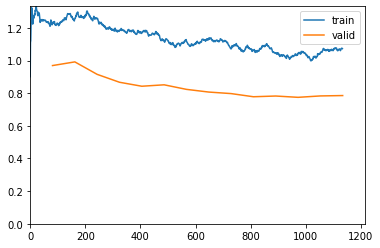

Better model found at epoch 2 with valid_loss value: 0.9152663946151733.
Better model found at epoch 3 with valid_loss value: 0.8669390678405762.
Better model found at epoch 4 with valid_loss value: 0.8425377607345581.
Better model found at epoch 6 with valid_loss value: 0.8233784437179565.
Better model found at epoch 7 with valid_loss value: 0.8068963289260864.
Better model found at epoch 8 with valid_loss value: 0.7975178360939026.
Better model found at epoch 9 with valid_loss value: 0.7781533002853394.
Better model found at epoch 11 with valid_loss value: 0.7746047973632812.
No improvement since epoch 11: early stopping


In [83]:
learn.fine_tune(15,freeze_epochs=2)

In [84]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [85]:
learn.dls = dlsTest

In [86]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5935564041137695.


(#4) [0.7494146823883057,0.5935564041137695,0.6409691629955947,0.6381578947368421]

## Faltten + Label

In [87]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.216468,0.814852,0.614679,0.600610,0.619497,00:37
1,0.901242,0.697008,0.607034,0.618677,0.500000,00:36


Better model found at epoch 0 with valid_loss value: 0.8148524761199951.


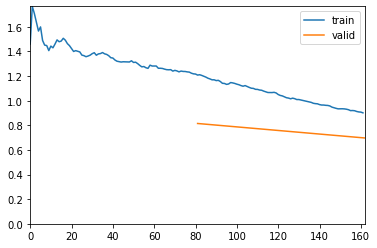

Better model found at epoch 1 with valid_loss value: 0.6970077157020569.


In [88]:
learn.fit_flat_cos(2,lr=1e-3)

In [89]:
learn.unfreeze()

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=7.585775847473997e-07)

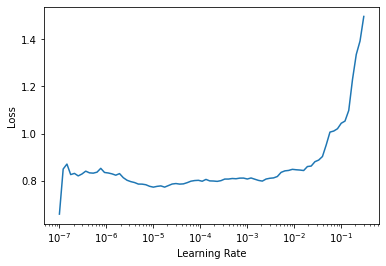

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.997514,1.241144,0.504587,0.400000,0.037736,00:43
1,1.015676,0.875814,0.490826,0.488408,0.993711,00:43
2,0.985253,2.542255,0.487768,0.485666,0.905660,00:42
3,1.057460,516.529480,0.513761,0.500000,0.251572,00:42
4,1.083597,0.723872,0.513761,0.000000,0.000000,00:43
5,0.959825,1.065906,0.501529,0.493569,0.965409,00:42
6,0.986944,0.790574,0.487768,0.326531,0.050314,00:43
7,0.899809,0.834053,0.519878,0.642857,0.028302,00:42


Better model found at epoch 0 with valid_loss value: 1.241144061088562.


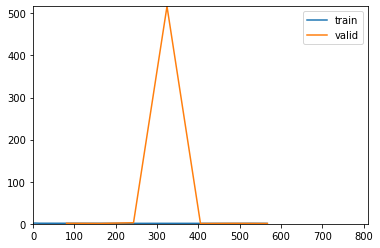

Better model found at epoch 1 with valid_loss value: 0.8758140802383423.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with valid_loss value: 0.7238717079162598.
No improvement since epoch 4: early stopping


In [91]:
learn.fit_flat_cos(10,lr=1e-2)

In [92]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [93]:
learn.dls = dlsTest

In [94]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7548167705535889,0.4349442422389984,0.0,0.0]

## Label + MixUp

In [95]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.276306,1.006300,0.548930,0.536050,0.537736,00:37
1,1.081340,0.771766,0.568807,0.563380,0.503145,00:36


Better model found at epoch 0 with valid_loss value: 1.0063002109527588.


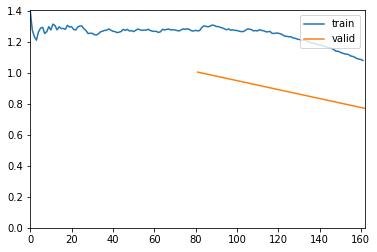

Better model found at epoch 1 with valid_loss value: 0.7717664241790771.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.814087,0.679509,0.596330,0.591837,0.547170,00:43
1,0.773699,0.675730,0.591743,0.577508,0.597484,00:43
2,0.738642,0.643547,0.637615,0.609756,0.707547,00:43
3,0.711575,0.668322,0.593272,0.572222,0.647799,00:42
4,0.691713,0.650930,0.610092,0.658291,0.411950,00:43
5,0.686045,0.668527,0.597859,0.591973,0.556604,00:43


Better model found at epoch 0 with valid_loss value: 0.6795085668563843.


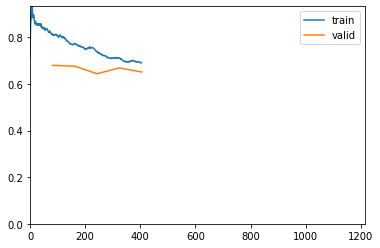

Better model found at epoch 1 with valid_loss value: 0.6757295727729797.
Better model found at epoch 2 with valid_loss value: 0.6435470581054688.
No improvement since epoch 2: early stopping


In [96]:
learn.fine_tune(15,freeze_epochs=2)

In [97]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [98]:
learn.dls = dlsTest

In [99]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6418834924697876.


(#4) [0.6440915465354919,0.6418834924697876,0.681917211328976,0.6864035087719298]